# Function to access the Wbcam 

In [1]:
%matplotlib notebook

# import the opencv library
import cv2

# define a video capture object. 
# To open default camera using default backend just pass 0
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")
    
    
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# 
while True:
    # Capture the video frame by frame
    ret, frame = cap.read()
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Video', frame)
    
    # break the loop on escape key
    c = cv2.waitKey(1)
    if c == 27:
        break
  
# done with the camera window.
cap.release()
cv2.destroyAllWindows()

# Dataset

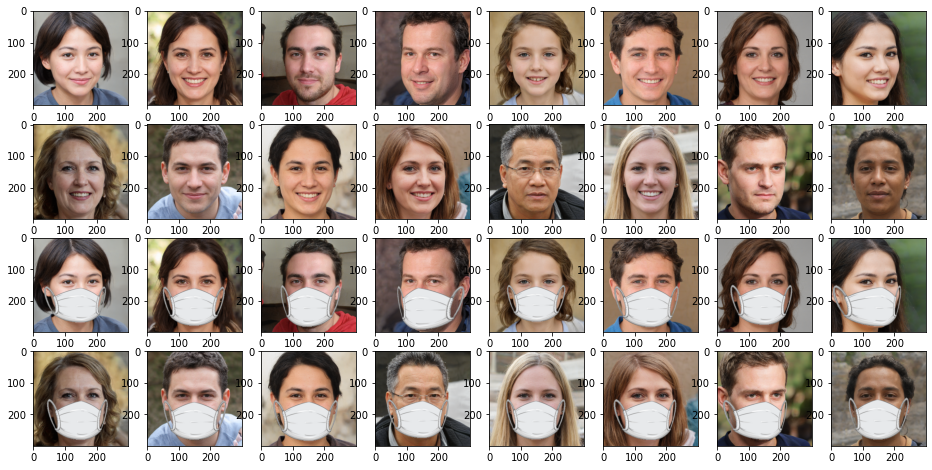

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


def img_reshape(path, img):
    img = Image.open(path+img).convert('RGB')
    img = img.resize((300,300))
    img = np.asarray(img)
    return img

path = 'DataSet/TestSet/'
images = os.listdir(path)
img_arr = []

for image in images:
    img_arr.append(img_reshape(path, image))
    
rows = 4
cols = 8
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16,8))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(images):
            axes[i, j].imshow(img_arr[img_count])
            img_count+=1

# Preprocessing the images 

In [4]:
# All required imports
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Path where the images are kept
dataPath = "DataSet"

# Here we get the subfolders names as catagories (MaskOn & MaskOff)
trainingFolders  =   ["MaskOff", "MaskOn"]

#
imgDim          =   100  # To resize the image in imgDim*imgDim dimension
trainingData    =   []
trainingLable   =   []


# Looping into "dataPath" for both folders it has
for category in trainingFolders:
    count = 0
    folderPath = os.path.join(dataPath, category)
    # list all the images in folders
    allImgs = os.listdir(folderPath)
    
    print("\n{} folder has {} count of images.".format(category, len(allImgs)))
    
    # Process images one by one 
    for imgName in allImgs:
        imgPath = os.path.join(folderPath, imgName)
        img = cv2.imread(imgPath)
        
        # Just to print the count
        count += 1
        print('\rProcessing img count : '+str(count), end='', flush=True)
        ############## Initiate Process ###############
        # Let's covert the image into gray scale
        grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)           
        
        # Now resize the gray scale into imgDim*imgDim 
        resizedImg = cv2.resize(grayImg, (imgDim, imgDim))
        
        # Append the resizedImg and Labels to the training dataSet array
        trainingData.append(resizedImg)
        trainingLable.append(category)
        
        ### Normalization of trainingData
        # When using the image as it is and passing through a Deep Neural Network, 
        # the computation of high numeric values may become more complex.
        # To reduce this we can normalize the values to range from 0 to 1.
        # As the pixel values range from 0 to 256, apart from 0 the range is 255. 
        # So dividing all the values by 255 will convert it to range from 0 to 1.
        trainingDataNorm = np.array(trainingData)/255.0
        
        # As Neural N/W expects it as 4 Dim array, let's covert it to 4 Dim array
        trainingDataArr = np.reshape(trainingDataNorm,(trainingDataNorm.shape[0], imgDim, imgDim, 1))
        
        # Convert Lables to array
        trainingArr = np.array(trainingLable)
        
        # integer encode
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(trainingArr)
        #print(integer_encoded)
        
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        trainingLableArr = onehot_encoder.fit_transform(integer_encoded)
        #print(trainingLableArr)
        
        #  Let's save the arrays to a binary file in NumPy .npy format.
        np.save('trainingDataArr', trainingDataArr)
        np.save('trainingLableArr', trainingLableArr)

MaskOff folder has 1000 count of images.
Processing img count : 1000MaskOn folder has 1000 count of images.
Processing img count : 1000

# Training CNN on the processed Image

In [6]:
# All required imports
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense

# Supress some warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split

# loading the saved arrays (binary files) in the previous code
trainingDataArr = np.load('trainingDataArr.npy')
trainingLableArr = np.load('trainingLableArr.npy')

# Create an instance of Sequential
model=Sequential()

# The first CNN layer followed by Relu and MaxPooling layers
model.add(Conv2D(200,(3,3),input_shape=trainingDataArr.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# The second convolution layer followed by Relu and MaxPooling layers
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer to stack the output convolutions from second convolution layer
# Flatten is the function that converts the pooled feature map to a single column 
# that is passed to the fully connected layer. Dense adds the fully connected 
# layer to the neural network.
model.add(Flatten())

# The Dropout layer randomly sets input units to 0 with a frequency of rate at 
# each step during training time, which helps prevent overfitting. ... 
# Note that the Dropout layer only applies when training is set to True such 
# that no values are dropped during inference. When using model.
model.add(Dropout(0.5))

# Dense layer of 64 neurons
model.add(Dense(50,activation='relu'))

# The Final layer with two outputs for two categories
model.add(Dense(2,activation='softmax'))

# Compiling the model takes three parameters: optimizer, loss and metrics. 
# The optimizer controls the learning rate. ... Adam is generally a good optimizer 
# to use for many cases. The adam optimizer adjusts the learning rate throughout training.
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Test Train spliting the data (15% as test data)
train_images,test_images,train_labels,test_labels=train_test_split(trainingDataArr, trainingLableArr, test_size=0.1)

# Let's fit the model to CNN
history = model.fit(train_images, train_labels, epochs=3, validation_split=0.2)

# Evaluvate teh model
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
test_loss, test_acc = model.evaluate(test_images,test_labels)
print("loss : {}, accuracy : {}".format(test_loss, test_acc))




Train on 1440 samples, validate on 360 samples
Epoch 1/3
1440/1440 [==============================] - 67s 47ms/step - loss: 0.5393 - accuracy: 0.6799 - val_loss: 0.0854 - val_accuracy: 0.9917
Epoch 2/3
1440/1440 [==============================] - 68s 47ms/step - loss: 0.0500 - accuracy: 0.9812 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 3/3
1440/1440 [==============================] - 66s 46ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
200/200 [==============================] - 2s 12ms/step
loss : 0.002021030820906162, accuracy : 1.0


In [7]:
# save model and architecture to single file
model.save("FaceMaskDetection_Model.h5")
print("Saved model to disk")

Saved model to disk


In [1]:
from keras.models import load_model
model_loaded = load_model('FaceMaskDetection_Model.h5')

Using TensorFlow backend.
C:\Users\AR359535\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\AR359535\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\AR359535\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [5]:
%matplotlib notebook

# import the opencv library
import cv2
import numpy as np

imgDim          =   100  # To resize the image in imgDim*imgDim dimension

# define a video capture object. 
# To open default camera using default backend just pass 0
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")
    
    
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# 
labels_dict={0:'No MASK',1:'MASK'}
color_dict={0:(0,0,255),1:(0,255,0)}
#
while True:
    # Capture the video frame by frame
    ret, frame = cap.read()
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        face_img = gray[y:y+w,x:x+w]
        #grayImg = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY) 
        resizedImg = cv2.resize(face_img, (imgDim, imgDim))
        normalized=resizedImg/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model_loaded.predict(reshaped)
        label=np.argmax(result,axis=1)[0]
        
        #label = 1
        #cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.rectangle(frame, (x,y), (x+w,y+h), color_dict[label], 2)
        cv2.rectangle(frame, (x,y-40), (x+w,y), color_dict[label], -1)
        cv2.putText(frame, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        

    # Display the resulting frame
    cv2.imshow('Video', frame)
    
    # break the loop on escape key
    c = cv2.waitKey(1)
    if c == 27:
        break
  
# done with the camera window.
cap.release()
cv2.destroyAllWindows()

In [21]:
folderPath = "DataSet\TestSet"

# list all the images in folders
allImgs = os.listdir(folderPath)

# Process images one by one 
for imgName in allImgs:
    imgPath = os.path.join(folderPath, imgName)
    img = cv2.imread(imgPath)
    
    # Let's covert the image into gray scale
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)           
    # Now resize the gray scale into imgDim*imgDim 
    resizedImg = cv2.resize(grayImg, (imgDim, imgDim))
    normalized=resizedImg/255.0
    reshaped=np.reshape(normalized,(1,100,100,1))
    result=model.predict(reshaped)
    label=np.argmax(result,axis=1)[0]
    print("{} predicted as {}".format(imgName, label))

No (1).png predicted as 0
No (10).png predicted as 0
No (11).png predicted as 0
No (12).png predicted as 0
No (13).png predicted as 0
No (14).png predicted as 0
No (15).png predicted as 0
No (16).png predicted as 0
No (2).png predicted as 0
No (3).png predicted as 0
No (4).png predicted as 0
No (5).png predicted as 0
No (6).png predicted as 0
No (7).png predicted as 0
No (8).png predicted as 0
No (9).png predicted as 0
Yes (1).png predicted as 1
Yes (10).png predicted as 1
Yes (11).png predicted as 1
Yes (12).png predicted as 1
Yes (13).png predicted as 1
Yes (14).png predicted as 1
Yes (15).png predicted as 1
Yes (16).png predicted as 1
Yes (2).png predicted as 1
Yes (3).png predicted as 1
Yes (4).png predicted as 1
Yes (5).png predicted as 1
Yes (6).png predicted as 1
Yes (7).png predicted as 1
Yes (8).png predicted as 1
Yes (9).png predicted as 1


In [19]:
label

1